In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from skbio.stats.composition import ilr
import statsmodels.api as sm


 ## 1. Data Preparation - Car Ownership


In [2]:
# Load and clean car ownership data
cars_df = pd.read_excel("../data/housing/cars_or_vans_wards.xlsx", sheet_name="2021")

# Filter out City of London and invalid entries
cars_df = cars_df[(cars_df['local authority code'] != 'E09000001') &
                  (cars_df['All households '] > 0)].copy()

# Calculate percentages
categories = ['none', 'one', 'two', 'three or more']
total_households = cars_df['All households']

for cat in categories:
    cars_df[f'pct_{cat}_cars'] = cars_df[cat] / total_households

# Select relevant columns
keep_cols = ['ward code', 'ward name', 'local authority name'] + [f'pct_{cat}_cars' for cat in categories]
cars_clean = cars_df[keep_cols]


 ## 2. Burglary Data Processing
 Calculate burglary percentage at ward level


In [3]:

# Load and filter 2021 data
burglary = pd.read_csv("../data/residential_burglary.csv")
burglary_2021 = burglary[burglary['Year'] == 2021]

# Aggregate by ward
burglary_df = burglary_2021.groupby('Ward Code').size().reset_index(name='burglary_count')

# Calculate percentage
total_burglaries = burglary_df['burglary_count'].sum()
burglary_df['burglary_pct'] = (burglary_df['burglary_count'] / total_burglaries) * 100


 ## 3. Data Merging


In [4]:
merged = pd.merge(
    cars_clean,
    burglary_df,
    left_on="ward code",
    right_on="Ward Code",
    how="inner"
)

# Cleanup
merged = merged.dropna(subset=['burglary_pct'] + [f'pct_{cat}_cars' for cat in categories])


## 4. Advanced Correlation Analysis

In [5]:
# Create composite car index
merged['car_index'] = (
        0 * merged['pct_none_cars'] +
        1 * merged['pct_one_cars'] +
        2 * merged['pct_two_cars'] +
        3 * merged['pct_three or more_cars']
)

# Calculate correlations
correlations = {}
for cat in categories:
    corr, pval = pearsonr(merged[f'pct_{cat}_cars'], merged['burglary_pct'])
    correlations[cat] = (corr, pval)

index_corr, index_pval = pearsonr(merged['car_index'], merged['burglary_pct'])


 ## 5. Visualization


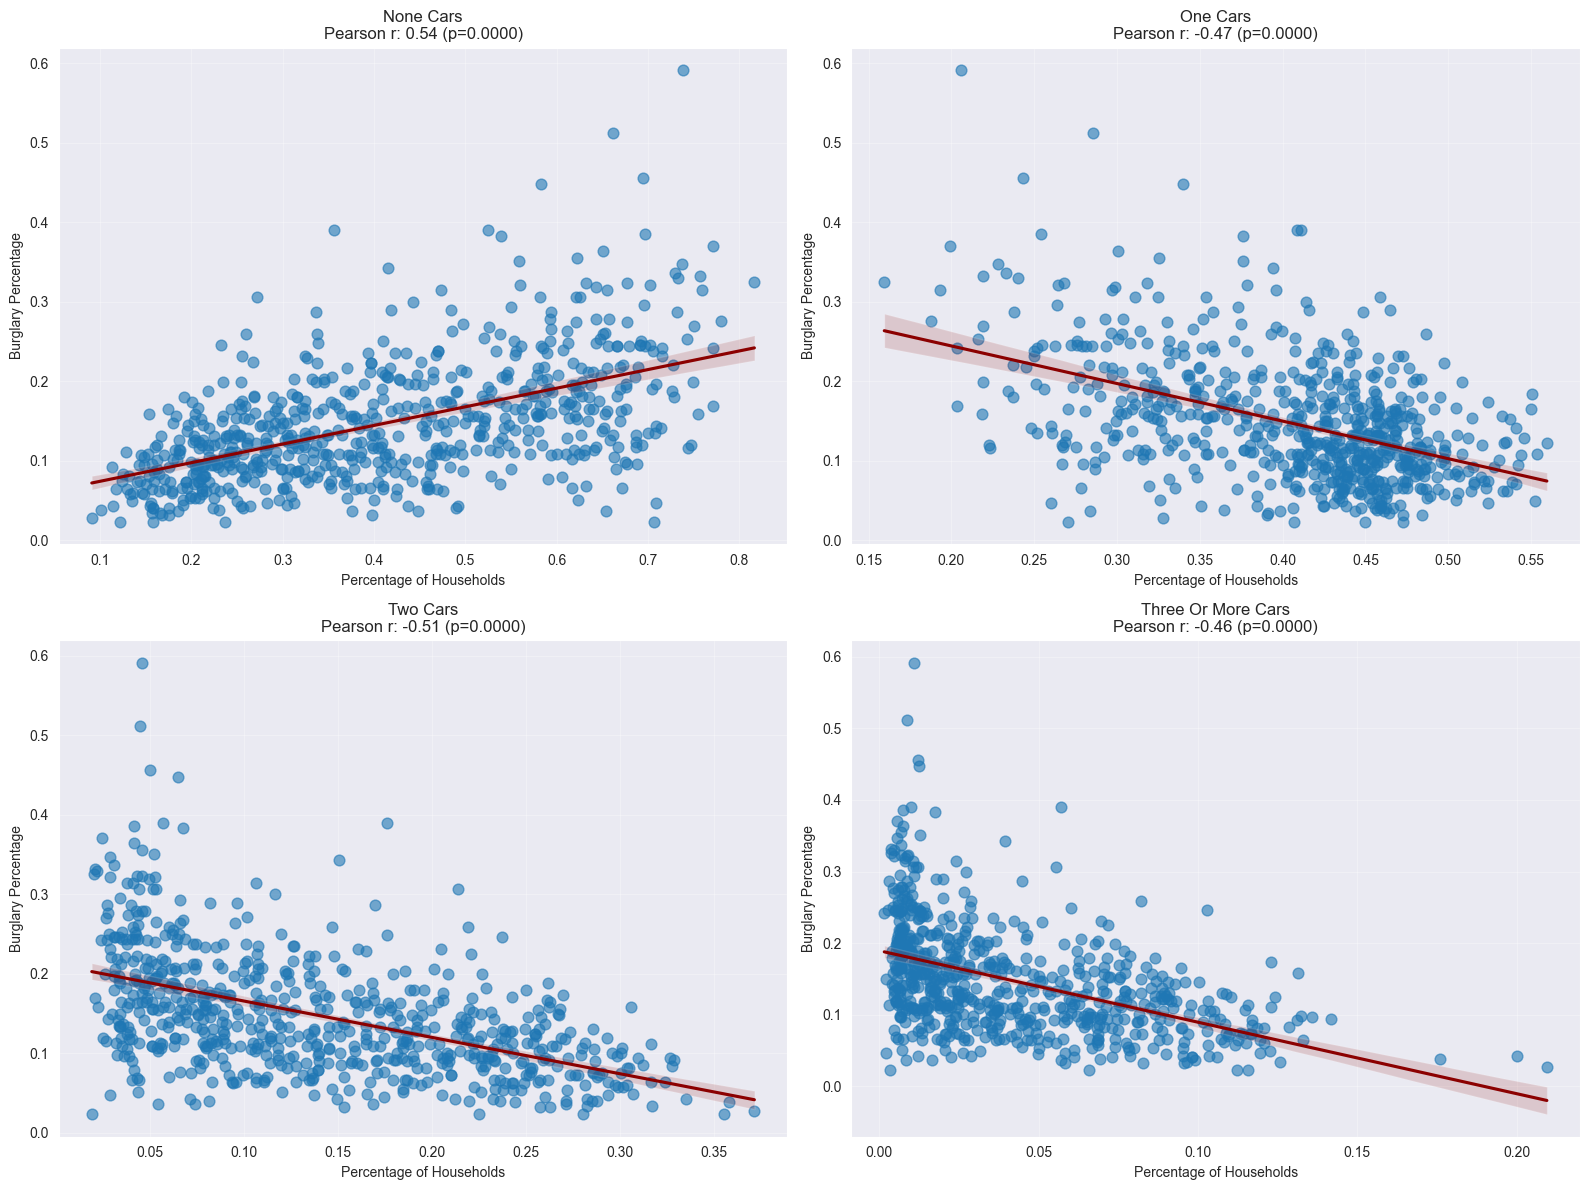

In [6]:
# Create figure grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, cat in enumerate(categories):
    ax = axes[idx]
    sns.regplot(
        x=merged[f'pct_{cat}_cars'],
        y=merged['burglary_pct'],
        ax=ax,
        scatter_kws={'alpha': 0.6, 's': 60},
        line_kws={'color': 'darkred'}
    )

    corr, pval = correlations[cat]
    title = f"{cat.title()} Cars\nPearson r: {corr:.2f} (p={pval:.4f})"
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Percentage of Households", fontsize=10)
    ax.set_ylabel("Burglary Percentage", fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Tier Analysis


C:\Users\gusta\AppData\Local\Temp\ipykernel_3424\2046490980.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = merged.groupby('car_tier')['burglary_pct'].agg(['mean', 'std', 'count'])


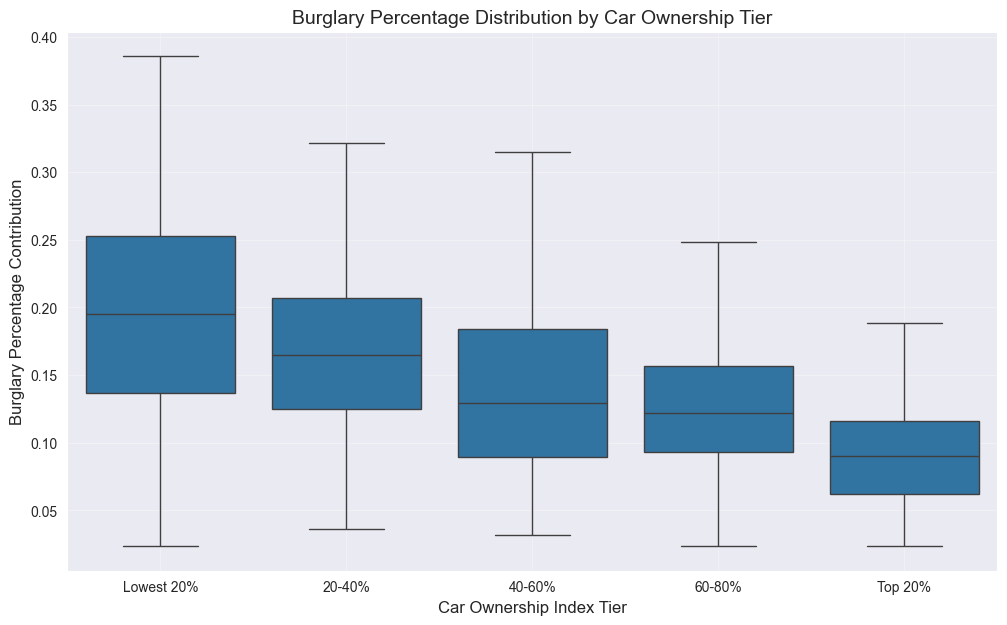

In [7]:
# Create car ownership tiers
merged['car_tier'] = pd.qcut(
    merged['car_index'],
    q=5,
    labels=['Lowest 20%', '20-40%', '40-60%', '60-80%', 'Top 20%']
)

# Calculate tier statistics
tier_stats = merged.groupby('car_tier')['burglary_pct'].agg(['mean', 'std', 'count'])

# Visualization
plt.figure(figsize=(12, 7))
sns.boxplot(
    x='car_tier',
    y='burglary_pct',
    data=merged,
    order=['Lowest 20%', '20-40%', '40-60%', '60-80%', 'Top 20%'],
    showfliers=False
)
plt.title("Burglary Percentage Distribution by Car Ownership Tier", fontsize=14)
plt.xlabel("Car Ownership Index Tier", fontsize=12)
plt.ylabel("Burglary Percentage Contribution", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


 ## 7. Key Findings


In [8]:
print("=== Key Correlations ===")
for cat in categories:
    corr, pval = correlations[cat]
    print(f"{cat.title()+':':<20} r = {corr:.2f} (p = {pval:.4f})")

print(f"\nCar Index Correlation: r = {index_corr:.2f} (p = {index_pval:.4f})")

print("\n=== Tier Statistics ===")
print(tier_stats)

=== Key Correlations ===
None:                r = 0.54 (p = 0.0000)
One:                 r = -0.47 (p = 0.0000)
Two:                 r = -0.51 (p = 0.0000)
Three Or More:       r = -0.46 (p = 0.0000)

Car Index Correlation: r = -0.53 (p = 0.0000)

=== Tier Statistics ===
                mean       std  count
car_tier                             
Lowest 20%  0.205841  0.091998    136
20-40%      0.172305  0.069106    135
40-60%      0.138693  0.061843    136
60-80%      0.129054  0.055446    135
Top 20%     0.091616  0.039733    136


## 8. Multivariate Regression with ILR (isometric log-ratio)

In [9]:
# Create composition matrix
composition = merged[['pct_none_cars', 'pct_one_cars',
                     'pct_two_cars', 'pct_three or more_cars']].values + 1e-6  # Add small epsilon for zeros

# Perform ILR transformation
ilr_transformed = ilr(composition)

# Create ILR coordinate names
ilr_cols = [f'ILR_{i+1}' for i in range(ilr_transformed.shape[1])]
merged_ilr = merged.join(pd.DataFrame(ilr_transformed, columns=ilr_cols))

# Fit regression model
X = merged_ilr[ilr_cols]
X = sm.add_constant(X)
y = merged_ilr['burglary_pct']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           burglary_pct   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     97.93
Date:                Tue, 13 May 2025   Prob (F-statistic):           1.29e-52
Time:                        20:55:32   Log-Likelihood:                 904.81
No. Observations:                 678   AIC:                            -1802.
Df Residuals:                     674   BIC:                            -1784.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1718      0.016     11.023      0.0